In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business', 'general'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [77]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 7216462#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

1701127
Title: Black medicine for athletes - Thairath
Description: This article from the page Avarin Running and Triathlon. is useful. You will know the causes of death from sports that some people still don't know the cause of. I'd like to cut it for Thairath sports fans to read in some parts.
Original Language: Thai


In [78]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Black medicine for athletes - Thairath
Description: This article from the page Avarin Running and Triathlon. is useful. You will know the causes of death from sports that some people still don't know the cause of. I'd like to cut it for Thairath sports fans to read in some parts.
Original Language: Thai
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical

In [79]:
##############################################
motivation_raw = '''
{
  "introduction": "Recent reports, like the one in Thairath discussing unexpected deaths in sports, highlight a critical need to explore deeper. By gathering data on athletes' health histories, types of sports played, and circumstances of these incidents, we can identify patterns or common factors. This information can shed light on potential underlying causes and guide preventive measures in the sports community.",
  "title": "AthleteHealthSafetyAnalysis"
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [80]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [87]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Athlete Mortality Risk",
    "description": "Risk of mortality among athletes due to sports-related activities",
    "type": "outcome",
    "observed": true,
    "values": ["Low Risk", "High Risk"],
    "parents": ["Physical Stress Level", "Pre-Existing Health Condition", "Health Monitoring Frequency"]
  },
  {
    "name": "High-Intensity Training",
    "description": "Engagement in high-intensity training by athletes",
    "type": "treatment",
    "observed": true,
    "values": ["No High-Intensity Training", "High-Intensity Training"],
    "parents": ["Pre-Existing Health Condition"]
  },
  {
    "name": "Use of Performance-Enhancing Drugs",
    "description": "Usage of performance-enhancing drugs by athletes",
    "type": "treatment",
    "observed": true,
    "values": ["No Drugs", "Uses Drugs"],
    "parents": ["Age Group"]
  },
  {
    "name": "Pre-Existing Health Condition",
    "description": "Existence of pre-existing health conditions in athletes",
    "type": "confounder",
    "observed": true,
    "values": ["No Pre-Existing Condition", "Has Pre-Existing Condition"],
    "parents": []
  },
  {
    "name": "Age Group",
    "description": "Age group of the athletes",
    "type": "confounder",
    "observed": true,
    "values": ["Younger Athletes", "Older Athletes"],
    "parents": []
  },
  {
    "name": "Physical Stress Level",
    "description": "Level of physical stress experienced by athletes",
    "type": "mediator",
    "observed": true,
    "values": ["Low Stress", "High Stress"],
    "parents": ["High-Intensity Training", "Use of Performance-Enhancing Drugs"]
  },
  {
    "name": "Health Monitoring Frequency",
    "description": "Frequency of health monitoring in athletes",
    "type": "mediator",
    "observed": true,
    "values": ["Low Frequency", "High Frequency"],
    "parents": ["Age Group"]
  },
  {
    "name": "Public Awareness of Athlete Health Issues",
    "description": "Level of public awareness regarding health issues faced by athletes",
    "type": "collider",
    "observed": true,
    "values": ["Low Awareness", "High Awareness"],
    "parents": ["Physical Stress Level", "Athlete Mortality Risk"]
  }
]

'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

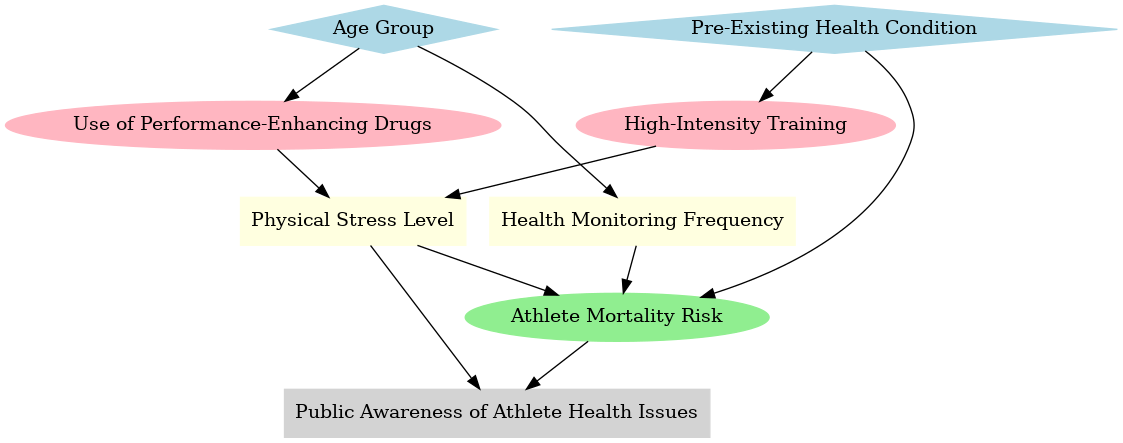

In [88]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [89]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

Recent reports, like the one in Thairath discussing unexpected deaths in sports, highlight a critical need to explore deeper. By gathering data on athletes' health histories, types of sports played, and circumstances of these incidents, we can identify patterns or common factors. This information can shed light on potential underlying causes and guide preventive measures in the sports community.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "affects", "confounder"/"confounding", "mediator"/"mediates") 

In [90]:
#################################################

structure_raw = '''
[
	{"sentence": "One interesting aspect is how the level of public awareness about athletes' health issues is influenced both by the physical stress athletes experience and the actual risk of mortality they face, suggesting that public perception is shaped by a combination of these factors.", "involved": ["Public Awareness of Athlete Health Issues", "Physical Stress Level", "Athlete Mortality Risk"]},
	{"sentence": "Athletes' engagement in high-intensity training, interestingly, is not just a personal choice but is also influenced by whether they have pre-existing health conditions, indicating a complex interplay between their health status and training decisions.", "involved": ["High-Intensity Training", "Pre-Existing Health Condition"]},
	{"sentence": "The frequency with which athletes monitor their health is affected by their age group, highlighting a potential generational divide in attitudes towards health management.", "involved": ["Health Monitoring Frequency", "Age Group"]},
	{"sentence": "It's notable that the physical stress level experienced by athletes is a result of both their training intensity and their use of performance-enhancing drugs, illustrating how these factors combine to impact their stress.", "involved": ["Physical Stress Level", "High-Intensity Training", "Use of Performance-Enhancing Drugs"]},
	{"sentence": "The risk of mortality among athletes is not only directly impacted by their physical stress levels but also by their pre-existing health conditions and how frequently they monitor their health, showing a multifaceted approach to understanding athletes' health risks.", "involved": ["Athlete Mortality Risk", "Physical Stress Level", "Pre-Existing Health Condition", "Health Monitoring Frequency"]},
	{"sentence": "Interestingly, athletes' use of performance-enhancing drugs is considered independent of other factors in this model, suggesting it as an area of individual choice within the athletic community.", "involved": ["Use of Performance-Enhancing Drugs"]}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [91]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

Recent reports, like the one in Thairath discussing unexpected deaths in sports, highlight a critical need to explore deeper. By gathering data on athletes' health histories, types of sports played, and circumstances of these incidents, we can identify patterns or common factors. This information can shed light on potential underlying causes and guide preventive measures in the sports community.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Pre-Existing Health Condition" is "Has Pre-Existing Condition" (rather than "No Pre-Existing Condition")?
2. when "Pre-Existing Health Condition" is "No Pre-Existing Condition": what is the probability that "High-Intensity Training" is "High-Intensity Training" (rather than "No High-Intensity Training")?
3. when "Pre-Existing Healt

In [92]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.2, 0.3],
  "2": [0.7, 0.8],
  "3": [0.4, 0.5],
  "4": [0.5, 0.6],
  "5": [0.3, 0.4],
  "6": [0.2, 0.3],
  "7": [0.1, 0.2],
  "8": [0.4, 0.5],
  "9": [0.7, 0.8],
  "10": [0.9, 0.95],
  "11": [0.6, 0.7],
  "12": [0.7, 0.8],
  "13": [0.1, 0.2],
  "14": [0.05, 0.1],
  "15": [0.3, 0.4],
  "16": [0.2, 0.3],
  "17": [0.4, 0.5],
  "18": [0.3, 0.4],
  "19": [0.6, 0.7],
  "20": [0.5, 0.6],
  "21": [0.4, 0.5],
  "22": [0.5, 0.6],
  "23": [0.6, 0.7],
  "24": [0.8, 0.9]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [93]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions)#.item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

----------------------------------  --------------------------  -----------------------  -----------------------------------------------------------------
High-Intensity Training             No High-Intensity Training  High-Intensity Training  Engagement in high-intensity training by athletes
Use of Performance-Enhancing Drugs  No Drugs                    Uses Drugs               Usage of performance-enhancing drugs by athletes
Athlete Mortality Risk              Low Risk                    High Risk                Risk of mortality among athletes due to sports-related activities
----------------------------------  --------------------------  -----------------------  -----------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Pre-Existing Health Condition' means Existence of pre-existing health conditions in athletes
'High-Intensity Training' means Engagement in high-intensity training by athletes
'Age Group' means Age group of the athletes
'Use of Performance-Enhancing Drugs' means Usage of performance-enhancing drugs by athletes
'Physical Stress Level' means Level of physical stress experienced by athletes
'Health Monitoring Frequency' means Frequency of health monitoring in athletes
'Athlete Mortality Risk' means Risk of mortality among athletes due to sports-related activities
'Public Awareness of Athlete Health Issues' means Level of public awareness regarding health issues faced by athletes
Treatment Value          Treatment                           Outcome Value    Outcome                       ATE    Correlation
-----------------------  ----------------------------------  ---------------  ----------------------  ---------  -------------
High-Intensity Training  High-Intensity Training             

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


AttributeError: 'float' object has no attribute 'item'

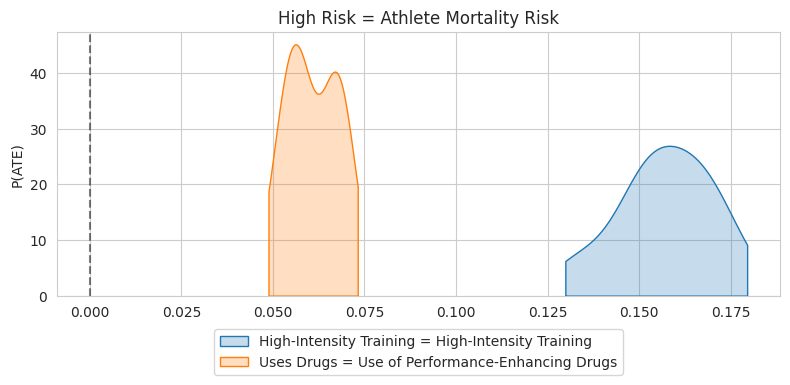

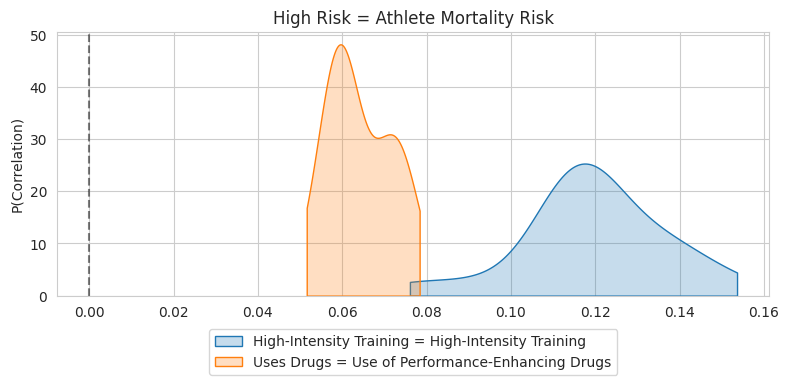

In [94]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [95]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Pre-Existing Health Condition' (0='No Pre-Existing Condition', 1='Has Pre-Existing Condition') means Existence of pre-existing health conditions in athletes
Variable 'High-Intensity Training' (0='No High-Intensity Training', 1='High-I

In [98]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Pre-Existing Health Condition": {
    "descriptor": ["the presence of pre-existing health issues", "the athletes' health history", "underlying health conditions among athletes"],
    "subject": "athletes",
    "predicate0": ["have no pre-existing health conditions", "are free from prior health issues"],
    "predicate1": ["have pre-existing health conditions", "are dealing with prior health issues"],
    "pronoun": "they",
    "nounclause0": ["athletes have no pre-existing health conditions", "athletes are free from prior health issues"],
    "nounclause1": ["athletes have pre-existing health conditions", "athletes are dealing with prior health issues"],
    "preposition": ["among", "within"],
    "domain": ["athletes", "sportspeople"],
    "subclause0": ["an athlete does not have any pre-existing health conditions", "there are no prior health issues for the athlete"],
    "subclause1": ["an athlete has pre-existing health conditions", "there are prior health issues for the athlete"],
    "condition0": ["if an athlete has no pre-existing health issues", "when athletes are free from prior health conditions"],
    "condition1": ["if an athlete has pre-existing health issues", "when athletes are dealing with prior health conditions"],
    "action0": ["an athlete overcomes prior health issues", "pre-existing conditions are resolved for an athlete"],
    "action1": ["an athlete develops pre-existing health issues", "pre-existing conditions emerge for an athlete"]
  },
  "High-Intensity Training": {
    "descriptor": ["the level of training intensity", "athletes' engagement in rigorous training", "the practice of high-intensity workouts"],
    "subject": "athletes",
    "predicate0": ["do not engage in high-intensity training", "avoid rigorous training routines"],
    "predicate1": ["engage in high-intensity training", "follow rigorous training routines"],
    "pronoun": "they",
    "nounclause0": ["athletes do not engage in high-intensity training", "athletes avoid rigorous training routines"],
    "nounclause1": ["athletes engage in high-intensity training", "athletes follow rigorous training routines"],
    "preposition": ["in", "among"],
    "domain": ["athletic regimes", "training programs"],
    "subclause0": ["high-intensity training is not part of the athlete's routine", "rigorous training is avoided"],
    "subclause1": ["high-intensity training is a key part of the athlete's routine", "rigorous training is embraced"],
    "condition0": ["when avoiding high-intensity training", "without rigorous training routines"],
    "condition1": ["when adopting high-intensity training", "with rigorous training routines in place"],
    "action0": ["an athlete stops high-intensity training", "high-intensity training is removed from the routine"],
    "action1": ["an athlete starts high-intensity training", "high-intensity training is introduced into the routine"]
  },
  "Age Group": {
    "descriptor": ["the age bracket of athletes", "the generational grouping of athletes", "athletes' age categories"],
    "subject": "athletes",
    "predicate0": ["belong to the younger age group", "are in the younger bracket"],
    "predicate1": ["belong to the older age group", "are in the older bracket"],
    "pronoun": "they",
    "nounclause0": ["athletes belong to the younger age group", "athletes are in the younger bracket"],
    "nounclause1": ["athletes belong to the older age group", "athletes are in the older bracket"],
    "preposition": ["among", "within"],
    "domain": ["sports teams", "athlete groups"],
    "subclause0": ["an athlete is part of the younger age group", "a younger bracket includes the athlete"],
    "subclause1": ["an athlete is part of the older age group", "an older bracket includes athlete"],
    "condition0": ["if an athlete is younger", "among the younger athletes"],
    "condition1": ["if an athlete is older", "among the older athletes"],
    "action0": ["an athlete moves into a younger age group", "a shift to the younger athlete bracket occurs"],
    "action1": ["an athlete moves into an older age group", "a shift to the older athlete bracket occurs"]
  },
  "Use of Performance-Enhancing Drugs": {
    "descriptor": ["the use of performance-enhancing drugs", "the prevalence of doping", "athletes' reliance on performance-boosting substances"],
    "subject": "athletes",
    "predicate0": ["do not use performance-enhancing drugs", "steer clear of doping"],
    "predicate1": ["use performance-enhancing drugs", "resort to doping"],
    "pronoun": "they",
    "nounclause0": ["athletes do not use performance-enhancing drugs", "athletes steer clear of doping"],
    "nounclause1": ["athletes use performance-enhancing drugs", "athletes resort to doping"],
    "preposition": ["in", "among"],
    "domain": ["sports leagues", "athletic competitions"],
    "subclause0": ["performance-enhancing drugs are not used by the athlete", "doping is not part of the athlete's practice"],
    "subclause1": ["performance-enhancing drugs are used by the athlete", "doping is part of the athlete's practice"],
    "condition0": ["if an athlete avoids performance-enhancing drugs", "without the use of doping substances"],
    "condition1": ["if an athlete uses performance-enhancing drugs", "with the use of doping substances"],
    "action0": ["an athlete stops using performance-enhancing drugs", "doping is abandoned by the athlete"],
    "action1": ["an athlete starts using performance-enhancing drugs", "doping is adopted by the athlete"]
  },
  "Physical Stress Level": {
    "descriptor": ["the level of physical stress", "athletes' stress from training", "the intensity of physical strain"],
    "subject": "athletes",
    "predicate0": ["experience low physical stress", "are under minimal physical strain"],
    "predicate1": ["experience high physical stress", "are under significant physical strain"],
    "pronoun": "they",
    "nounclause0": ["athletes experience low physical stress", "athletes are under minimal physical strain"],
    "nounclause1": ["athletes experience high physical stress", "athletes are under significant physical strain"],
    "preposition": ["under", "with"],
    "domain": ["training conditions", "athletic routines"],
    "subclause0": ["physical stress is low for the athlete", "minimal physical strain is evident"],
    "subclause1": ["physical stress is high for the athlete", "significant physical strain is evident"],
    "condition0": ["when experiencing low physical stress", "with minimal physical strain"],
    "condition1": ["when experiencing high physical stress", "under significant physical strain"],
    "action0": ["an athlete reduces their physical stress", "physical strain is lessened for the athlete"],
    "action1": ["an athlete increases their physical stress", "physical strain is heightened for the athlete"]
  },
  "Health Monitoring Frequency": {
    "descriptor": ["the frequency of health monitoring", "how often athletes check their health", "the regularity of health assessments"],
"subject": "athletes",
"predicate0": ["rarely monitor their health", "have infrequent health check-ups"],
"predicate1": ["regularly monitor their health", "have frequent health check-ups"],
"pronoun": "they",
"nounclause0": ["athletes rarely monitor their health", "athletes have infrequent health check-ups"],
"nounclause1": ["athletes regularly monitor their health", "athletes have frequent health check-ups"],
"preposition": ["among", "within"],
"domain": ["sports teams", "athletic groups"],
"subclause0": ["health monitoring is infrequent for the athlete", "there are only occasional health assessments"],
"subclause1": ["health monitoring is frequent for the athlete", "regular health assessments are a norm"],
"condition0": ["if health monitoring is infrequent", "with rare health assessments"],
"condition1": ["if health monitoring is frequent", "with regular health assessments"],
"action0": ["an athlete decreases their health monitoring frequency", "health check-ups become less frequent for the athlete"],
"action1": ["an athlete increases their health monitoring frequency", "health check-ups become more frequent for the athlete"]
},

  "Athlete Mortality Risk": {
    "descriptor": ["the risk of mortality in athletes", "the likelihood of athlete fatalities", "the mortality risk for athletes"],
    "subject": "athletes",
    "predicate0": ["are at a low risk of mortality", "face minimal risk of life-threatening incidents"],
    "predicate1": ["are at a high risk of mortality", "face a significant risk of life-threatening incidents"],
    "pronoun": "they",
    "nounclause0": ["athletes are at a low risk of mortality", "athletes face minimal risk of life-threatening incidents"],
    "nounclause1": ["athletes are at a high risk of mortality", "athletes face a significant risk of life-threatening incidents"],
    "preposition": ["in", "among"],
    "domain": "sports communities",
    "subclause0": ["an athlete is at a low risk of mortality", "there is minimal risk of life-threatening incidents for an athlete"],
    "subclause1": ["an athlete is at a high risk of mortality", "there is a significant risk of life-threatening incidents for an athlete"],
    "condition0": ["if athletes are at a low risk of mortality", "when athletes face minimal risk of life-threatening incidents"],
    "condition1": ["if athletes are at a high risk of mortality", "when athletes face a significant risk of life-threatening incidents"],
    "action0": ["athletes reduce their risk factors", "preventative measures are taken"],
    "action1": ["athletes engage in higher-risk activities", "there is a lack of health monitoring"]
  },
  "Public Awareness of Athlete Health Issues": {
    "descriptor": ["the level of public awareness about athletes' health", "public understanding of athletes' health concerns"],
    "subject": "the public",
    "predicate0": ["is not well-informed about athletes' health issues", "lacks awareness of health risks faced by athletes"],
    "predicate1": ["is highly aware of athletes' health issues", "is well-informed about health risks faced by athletes"],
    "pronoun": "they",
    "nounclause0": ["the public is not well-informed about athletes' health issues", "there is a lack of public awareness regarding athletes' health risks"],
    "nounclause1": ["the public is highly aware of athletes' health issues", "there is a strong public awareness regarding athletes' health risks"],
    "preposition": ["among", "in"],
    "domain": "the community",
    "subclause0": ["public awareness of athletes' health issues is low", "there is a lack of awareness about athletes' health in the community"],
    "subclause1": ["public awareness of athletes' health issues is high", "there is a strong awareness about athletes' health in the community"],
    "condition0": ["where public awareness is low", "in places with low public awareness of athletes' health issues"],
    "condition1": ["where public awareness is high", "in places with high public awareness of athletes' health issues"],
    "action0": ["public awareness of athletes' health issues is increased", "efforts are made to raise public awareness about athletes' health risks"],
    "action1": ["public awareness of athletes' health issues declines", "there is a decrease in public efforts to address athletes' health risks"]
  }
}


'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)
assert all(node['name'] in ctx['verbs'] for node in nodes), f'{[node["name"] for node in nodes if node["name"] not in ctx["verbs"]]!r}'

In [100]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

Recent reports, like the one in Thairath discussing unexpected deaths in sports, highlight a critical need to explore deeper. By gathering data on athletes' health histories, types of sports played, and circumstances of these incidents, we can identify patterns or common factors. This information can shed light on potential underlying causes and guide preventive measures in the sports community.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('High-Intensity Training') < 0
	2. ATE('Use of Performance-Enhancing Drugs') > 0
	3. ATE('High-Intensity Training') < ATE('Use of Performance-Enhancing Drugs')
	4. |ATE('High-Intensity Training')| < |ATE('Use of Performance-Enhancing Drugs')|
	5. CATE('High-Intensity Training' | 'Pre-Existing Health Condition' =

In [101]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {"question": "Does engaging in high-intensity training decrease the risk of mortality among athletes?", "answer": "no", "claim": "Engaging in high-intensity training does not decrease the risk of mortality among athletes."},
    "2": {"question": "Does using performance-enhancing drugs increase the risk of mortality among athletes?", "answer": "yes", "claim": "Using performance-enhancing drugs increases the risk of mortality among athletes."},
    "3": {"question": "Is the risk increase from using performance-enhancing drugs greater than that from high-intensity training among athletes?", "answer": "yes", "claim": "The risk increase from using performance-enhancing drugs is greater than that from high-intensity training among athletes."},
    "4": {"question": "Is the absolute risk change from using performance-enhancing drugs greater than that from high-intensity training among athletes?", "answer": "yes", "claim": "The absolute risk change from using performance-enhancing drugs is greater than that from high-intensity training among athletes."},
    "5": {"question": "For athletes without pre-existing health conditions, does high-intensity training increase their mortality risk?", "answer": "yes", "claim": "For athletes without pre-existing health conditions, high-intensity training increases their mortality risk."},
    "6": {"question": "For athletes without pre-existing health conditions, does using performance-enhancing drugs increase their mortality risk?", "answer": "yes", "claim": "For athletes without pre-existing health conditions, using performance-enhancing drugs increases their mortality risk."},
    "7": {"question": "For athletes without pre-existing health conditions, is the risk increase from using performance-enhancing drugs greater than from high-intensity training?", "answer": "yes", "claim": "For athletes without pre-existing health conditions, the risk increase from using performance-enhancing drugs is greater than from high-intensity training."},
    "8": {"question": "For athletes without pre-existing health conditions, is the absolute risk change from using performance-enhancing drugs greater than from high-intensity training?", "answer": "yes", "claim": "For athletes without pre-existing health conditions, the absolute risk change from using performance-enhancing drugs is greater than from high-intensity training."},
    "9": {"question": "For athletes with pre-existing health conditions, does high-intensity training decrease their mortality risk?", "answer": "no", "claim": "For athletes with pre-existing health conditions, high-intensity training does not decrease their mortality risk."},
    "10": {"question": "For athletes with pre-existing health conditions, does using performance-enhancing drugs increase their mortality risk?", "answer": "yes", "claim": "For athletes with pre-existing health conditions, using performance-enhancing drugs increases their mortality risk."},
    "11": {"question": "For athletes with pre-existing health conditions, is the risk increase from using performance-enhancing drugs greater than from high-intensity training?", "answer": "yes", "claim": "For athletes with pre-existing health conditions, the risk increase from using performance-enhancing drugs is greater than from high-intensity training."},
    "12": {"question": "For athletes with pre-existing health conditions, is the absolute risk change from using performance-enhancing drugs greater than from high-intensity training?", "answer": "yes", "claim": "For athletes with pre-existing health conditions, the absolute risk change from using performance-enhancing drugs is greater than from high-intensity training."},
    "13": {"question": "Does high-intensity training pose a greater mortality risk for athletes with pre-existing health conditions compared to those without?", "answer": "yes", "claim": "High-intensity training poses a greater mortality risk for athletes with pre-existing health conditions compared to those without."},
    "14": {"question": "Is the absolute change in mortality risk due to high-intensity training lower for athletes with pre-existing health conditions compared to those without?", "answer": "no", "claim": "The absolute change in mortality risk due to high-intensity training is not lower for athletes with pre-existing health conditions compared to those without."},
    "15": {"question": "Does using performance-enhancing drugs pose a greater mortality risk for athletes without pre-existing health conditions compared to those with?", "answer": "no", "claim": "Using performance-enhancing drugs does not pose a greater mortality risk for athletes without pre-existing health conditions compared to those with."},
    "16": {"question": "Is the absolute change in mortality risk due to using performance-enhancing drugs lower for athletes with pre-existing health conditions compared to those without?", "answer": "no", "claim": "The absolute change in mortality risk due to using performance-enhancing drugs is not lower for athletes with pre-existing health conditions compared to those without."},
    "17": {"question": "For younger athletes, does high-intensity training increase their mortality risk?", "answer": "yes", "claim": "For younger athletes, high-intensity training increases their mortality risk."},
    "18": {"question": "For younger athletes, does using performance-enhancing drugs decrease their mortality risk?", "answer": "no", "claim": "For younger athletes, using performance-enhancing drugs does not decrease their mortality risk."},
    "19": {"question": "For younger athletes, is the risk increase from using performance-enhancing drugs less than from high-intensity training?", "answer": "no", "claim": "For younger athletes, the risk increase from using performance-enhancing drugs is not less than from high-intensity training."},
    "20": {"question": "For younger athletes, is the absolute risk change from using performance-enhancing drugs greater than from high-intensity training?", "answer": "yes", "claim": "For younger athletes, the absolute risk change from using performance-enhancing drugs is greater than from high-intensity training."},
    "21": {"question": "For older athletes, does high-intensity training increase their mortality risk?", "answer": "yes", "claim": "For older athletes, high-intensity training increases their mortality risk."},
    "22": {"question": "For older athletes, does using performance-enhancing drugs decrease their mortality risk?", "answer": "no", "claim": "For older athletes, using performance-enhancing drugs does not decrease their mortality risk."},
    "23": {"question": "For older athletes, is the risk increase from high-intensity training less than from using performance-enhancing drugs?", "answer": "no", "claim": "For older athletes, the risk increase from high-intensity training is not less than from using performance-enhancing drugs."},
    "24": {"question": "For older athletes, is the absolute risk change from using performance-enhancing drugs greater than from high-intensity training?", "answer": "yes", "claim": "For older athletes, the absolute risk change from using performance-enhancing drugs is greater than from high-intensity training."},
    "25": {"question": "Does high-intensity training pose a greater mortality risk for younger athletes compared to older athletes?", "answer": "no", "claim": "High-intensity training does not pose a greater mortality risk for younger athletes compared to older athletes."},
    "26": {"question": "Is the absolute change in mortality risk due to high-intensity training lower for younger athletes compared to older athletes?", "answer": "no", "claim": "The absolute change in mortality risk due to high-intensity training is not lower for younger athletes compared to older athletes."},
"27": {"question": "Does using performance-enhancing drugs pose a greater mortality risk for younger athletes compared to older athletes?", "answer": "no", "claim": "Using performance-enhancing drugs does not pose a greater mortality risk for younger athletes compared to older athletes."},
"28": {"question": "Is the absolute change in mortality risk due to using performance-enhancing drugs greater for older athletes compared to younger athletes?", "answer": "yes", "claim": "The absolute change in mortality risk due to using performance-enhancing drugs is greater for older athletes compared to younger athletes."}
}
    
'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [102]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'AthleteHealthSafetyAnalysis.json'